# Determining the cost of cars

## Project description

The service for the sale of used cars "Not beaten, not painted" is developing an application to attract new customers. It will allow you to find out the market value of your car.

**Task:** 
- Build a model that can determine the market value of a car.

**Important criteria:**
- Quality of prediction;
- Training time of the model;
- Prediction time of the model.

**Plan of work:**
- Data loading
- Pre-processing
- Exploratory analysis 
- Correlation analysis
- Data preparation
- Model training
- Summarising the results of the work

**Description of data - file `autos.csv`**

- `DateCrawled` - date when the questionnaire was downloaded from the database
- `VehicleType` - car body type
- `RegistrationYear` - year of car registration
- `Gearbox` - type of gearbox
- `Power` - power (hp)
- `Model` - car model
- `Kilometre` - mileage (km)
- `RegistrationMonth` - vehicle registration month
- `FuelType` - fuel type
- `Brand` - make of the car
- `Repaired` - whether the car has been repaired or not.
- `DateCreated` - date when the questionnaire was created
- `NumberOfPictures` - number of photos of the car
- `PostalCode` - postcode of the questionnaire owner (user).
- `LastSeen` - date of last activity of the user
- `Price` - price in euros (***target***)

## Loading data

Loading libraries

In [1]:
%pip install phik
%pip install --upgrade scikit-learn
%pip install lightgbm
%pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmitr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings


from phik.report import plot_correlation_matrix

from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

Settings

In [3]:
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")

Save the file to a dataframe

In [4]:
try:
    autos = pd.read_csv('datasets/autos.csv')
except:
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Let's take a look at some general information about the dataframe

In [5]:
autos.info()
display(autos.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
157358,2016-04-01 21:47:15,500,sedan,1991,manual,116,80,150000,10,petrol,audi,no,2016-04-01 00:00:00,0,28197,2016-04-05 19:45:09
220863,2016-03-18 15:43:17,3750,bus,2012,manual,75,combo,150000,3,gasoline,opel,no,2016-03-18 00:00:00,0,4860,2016-04-05 22:17:44
327023,2016-03-27 15:49:35,7190,wagon,2007,manual,143,3er,150000,9,gasoline,bmw,no,2016-03-27 00:00:00,0,85748,2016-04-07 13:17:54
244479,2016-03-23 21:48:02,4900,wagon,2005,manual,140,a4,150000,9,gasoline,audi,no,2016-03-23 00:00:00,0,44534,2016-03-31 10:45:59
124948,2016-03-31 13:52:28,7750,suv,2010,manual,86,duster,60000,3,gasoline,dacia,no,2016-03-31 00:00:00,0,30163,2016-04-04 05:53:07


- There are omissions in the `VehicleType`, `Gearbox`, `Model`, `FuelType` and `Repaired` columns;
- The columns `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode` and `LastSeen` are irrelevant as they do not affect the model predictions;
- It is possible to cast all column names to snake case

## Data preprocessing

Getting rid of the columns `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode` and `LastSeen` that we do not need

In [6]:
autos.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'], inplace=True)

Changing the column names

In [7]:
autos.rename(columns={
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type'
}, inplace=True)

autos.columns = autos.columns.str.lower()

Looking at the unique values on each column

In [8]:
for column in autos.select_dtypes(include=['object']).columns:
    print(f'Unique values in {column} column: {autos[column].unique()}')

Unique values in vehicle_type column: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Unique values in gearbox column: ['manual' 'auto' nan]
Unique values in model column: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' '

Looking at the omissions for each column

In [9]:
missing_info = pd.DataFrame({
    'missing_values': autos.isna().sum(),
    'percentage': round((autos.isna().sum() / autos.shape[0]) * 100, 2)

})

missing_info

,missing_values,percentage
price,0,0.00
vehicle_type,37490,10.58
registration_year,0,0.00
gearbox,19833,5.60
power,0,0.00
model,19705,5.56
kilometer,0,0.00
registration_month,0,0.00
fuel_type,32895,9.28
brand,0,0.00


Filling the missing column values with the value `unknown` so that this is a separate category for our model

In [10]:
autos.fillna('unknown', inplace=True)

missing_info = pd.DataFrame({
    'missing_values': autos.isna().sum(),
    'percentage': round((autos.isna().sum() / autos.shape[0]) * 100, 2)

})

missing_info

,missing_values,percentage
price,0,0.0
vehicle_type,0,0.0
registration_year,0,0.0
gearbox,0,0.0
power,0,0.0
model,0,0.0
kilometer,0,0.0
registration_month,0,0.0
fuel_type,0,0.0
brand,0,0.0


Looking at the full duplicates in the table

In [11]:
print('Number of duplicates before processing:', autos.duplicated().sum())
autos.drop_duplicates(inplace=True)
print('Number of duplicates after processing:', autos.duplicated().sum())

Number of duplicates before processing: 27543
Number of duplicates after processing: 0


## Exploratory Data Analysis

### Functions

In [12]:
#Function to describe categorical data
def categorical_analysis(data, width=15, height=5, degree=0):
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    n_cols = 2
    n_rows = (len(categorical_columns) + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(width, n_rows * height))
    axes = axes.ravel()

    for i, column in enumerate(categorical_columns):
        #Selecting the 10 most popular categories
        top_categories = data[column].value_counts().nlargest(10).index
        filtered_data = data[data[column].isin(top_categories)]

        sns.countplot(x=column, data=filtered_data, palette="Set2", order=top_categories, ax=axes[i])
        axes[i].set_title(f'Top 10 categories in {column} column')
        axes[i].set_ylabel('Number of values')
        axes[i].set_xlabel('Category')
        axes[i].tick_params(axis='x', rotation=degree)

    plt.tight_layout()
    plt.show()

#Function to describe quantitative data
def numerical_analysis(data, bins=30, kde=True, width=15, height=5):
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
    n_cols = 2  
    n_rows = len(numerical_columns) 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(width, n_rows * height / 2))
    axes = axes.ravel()  

    for i, column in enumerate(numerical_columns):
        sns.histplot(data[column], kde=kde, bins=bins, ax=axes[i*2])
        axes[i*2].set_title(f'Histogram for {column} column')
        axes[i*2].set_ylabel('Quantity')
        axes[i*2].set_xlabel('Value')

        sns.boxplot(x=data[column], ax=axes[i*2 + 1])
        axes[i*2 + 1].set_title(f'Boxplot for {column} column')
        axes[i*2 + 1].set_xlabel('Value')

    plt.tight_layout()
    plt.show()

### Categorical Feature Analysis

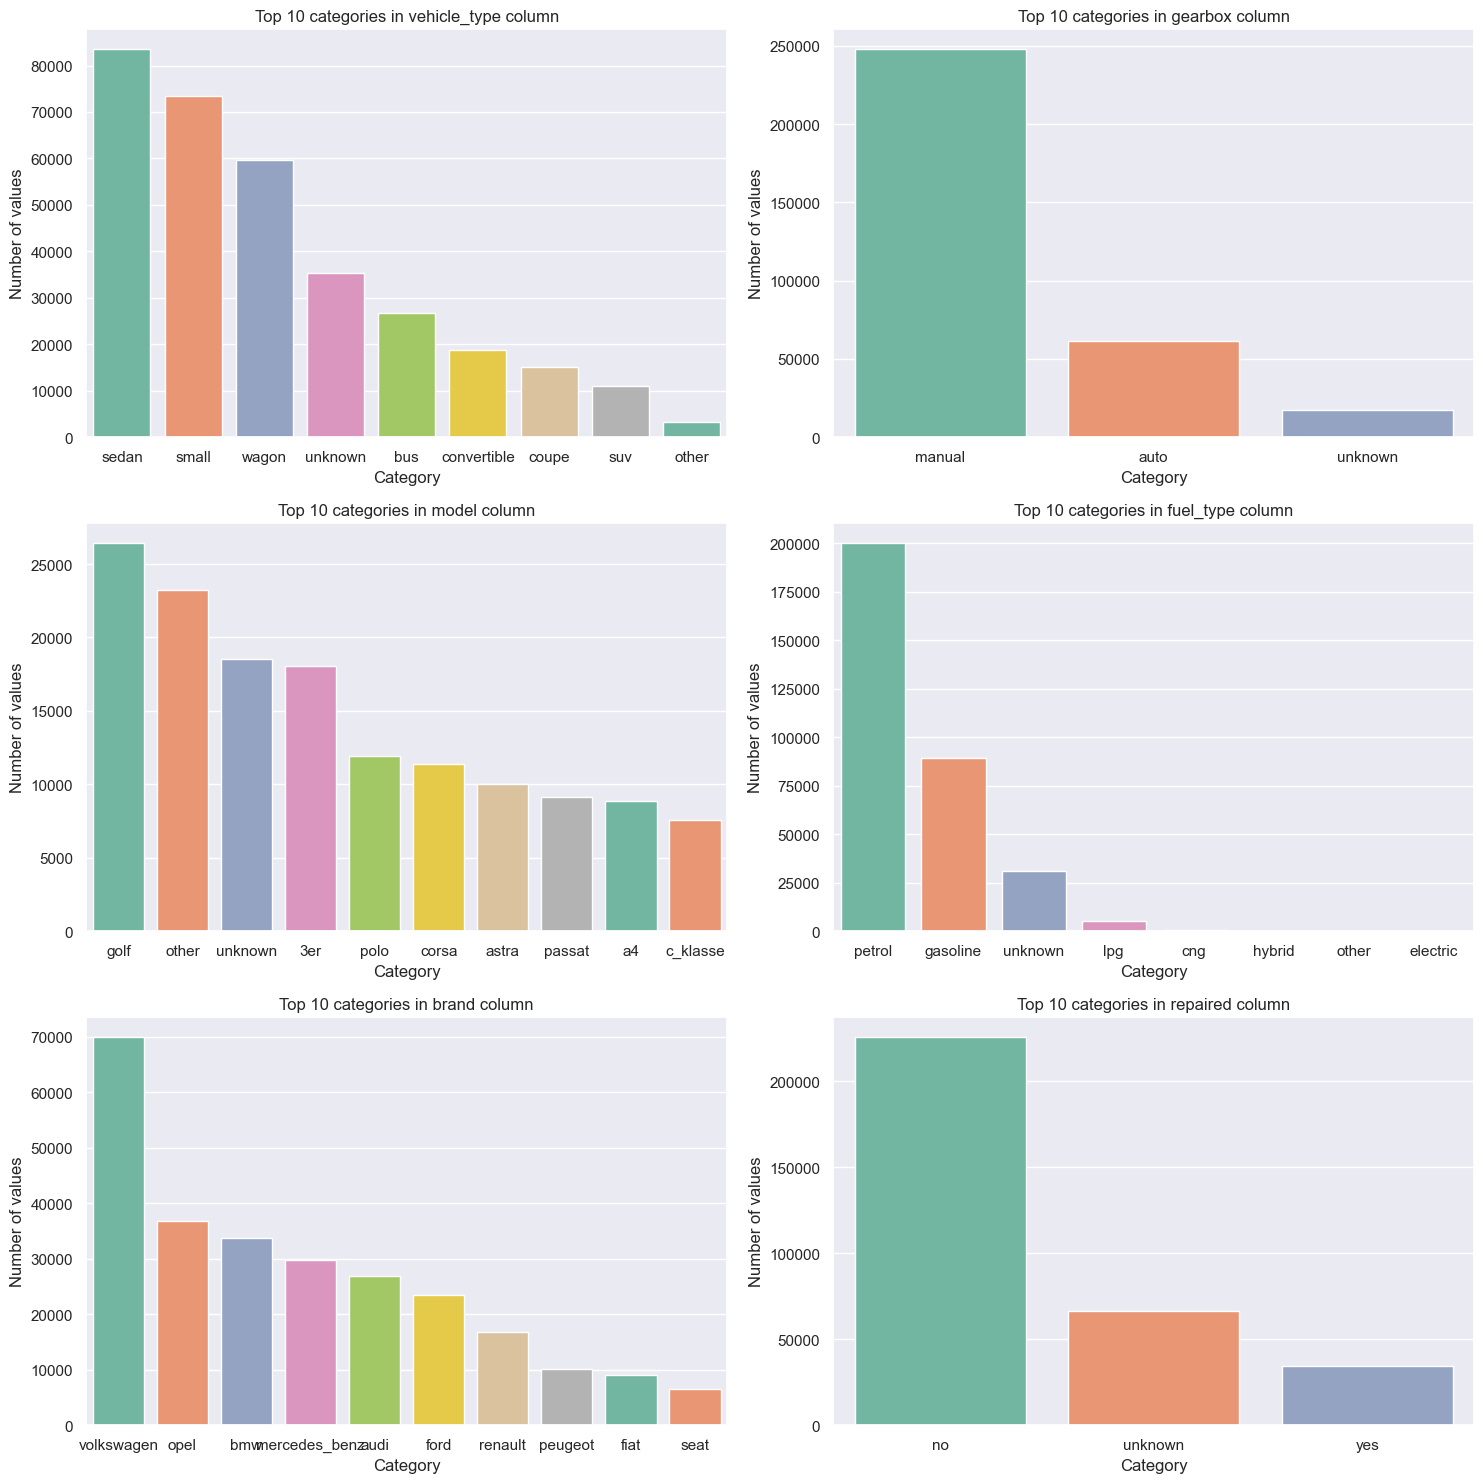

In [13]:
categorical_analysis(autos)

- The most popular types of cars are `sedan`, `small`, `wagon`;
- Most cars have a `manual` type of gearbox;
- The most popular car model is `golf`.
- The absolute majority of cars have fuel type - `petrol`.
- The most common car manufacturer - `volkswagen`.
- More than 200 thousand cars - not repaired

### Numerical Feature Analysis

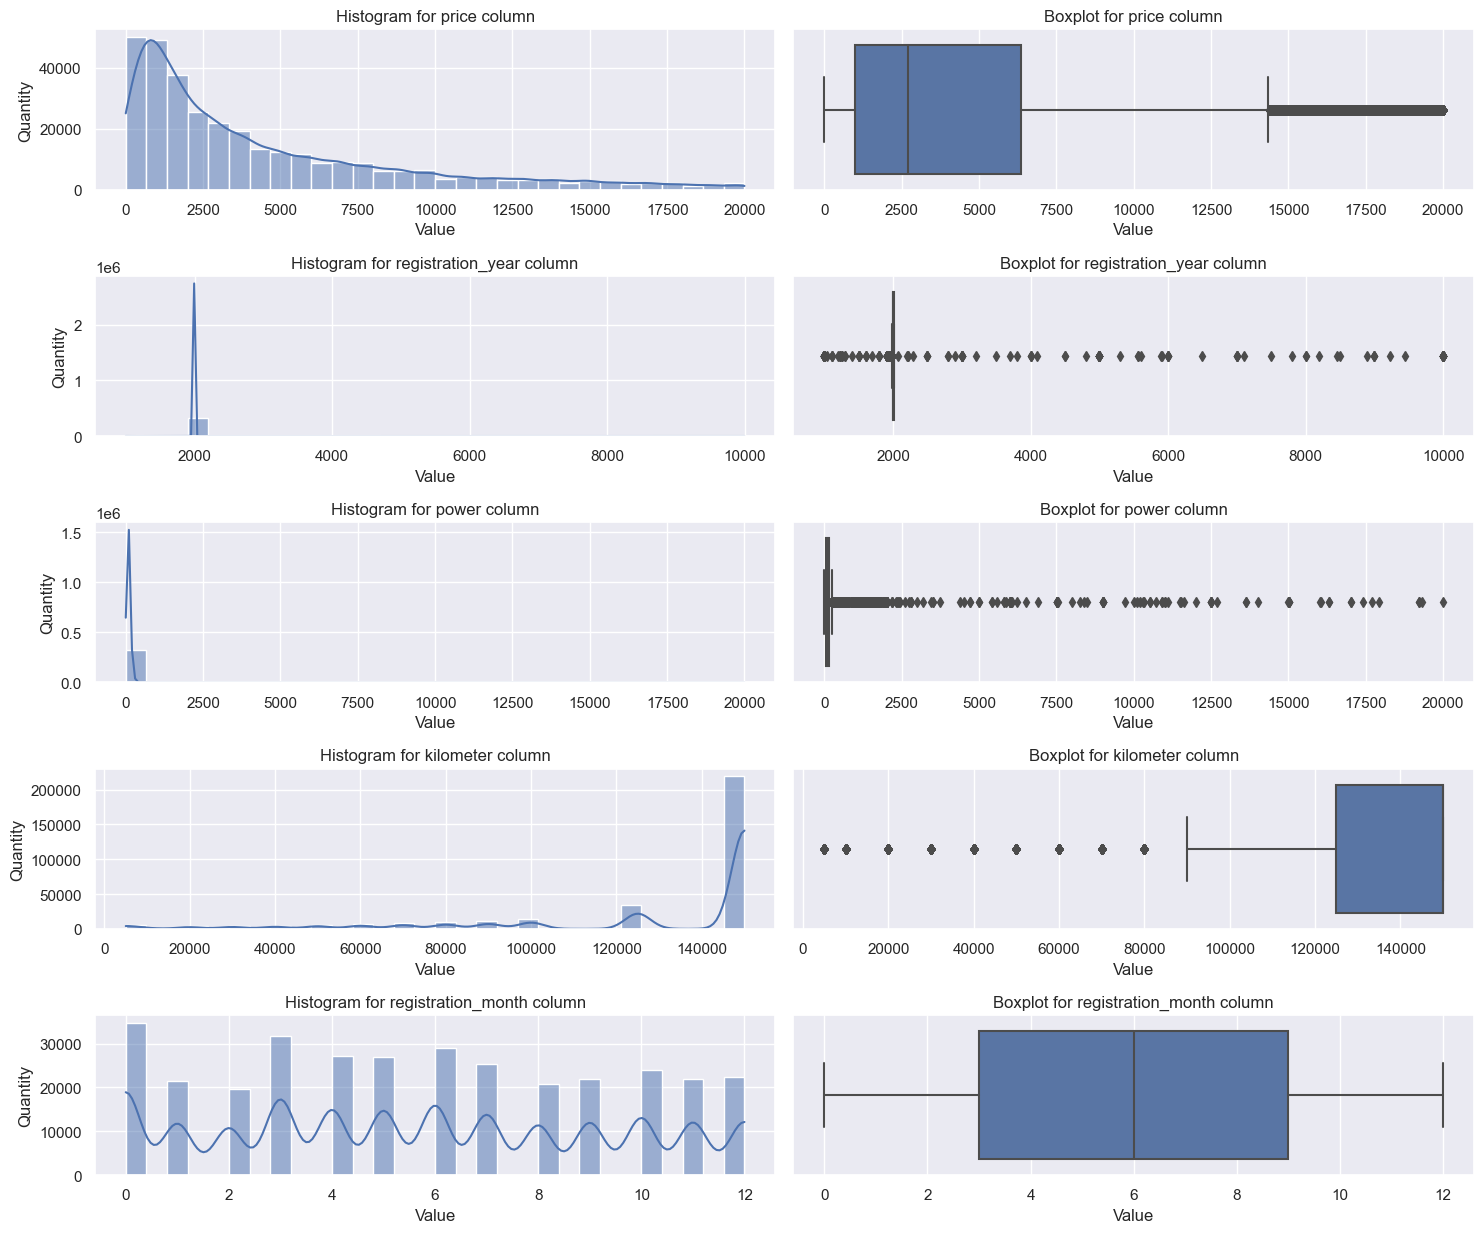

In [14]:
numerical_analysis(autos)

Note that there are anomalies in the `registration_year` column. Obviously, cars after 2023 don't exist yet, so we'll just get rid of them. Also, we will not take into account cars manufactured before 1960

In [15]:
n = len(autos)
autos = autos[(autos['registration_year'] <= 2023) & (autos['registration_year'] >= 1960)]
print(f'We saved {round(len(autos) / n * 100, 2)}% of data.')

We saved 99.85% of data.


We also get rid of lines where the value of `power` is more than 800

In [16]:
n = len(autos)
autos = autos[autos['power'] <= 800]
print(f'We saved {round(len(autos) / n * 100, 2)}% of data.')

We saved 99.9% of data.


We don't touch the mileage as this could be valuable data

Looking at the distribution again

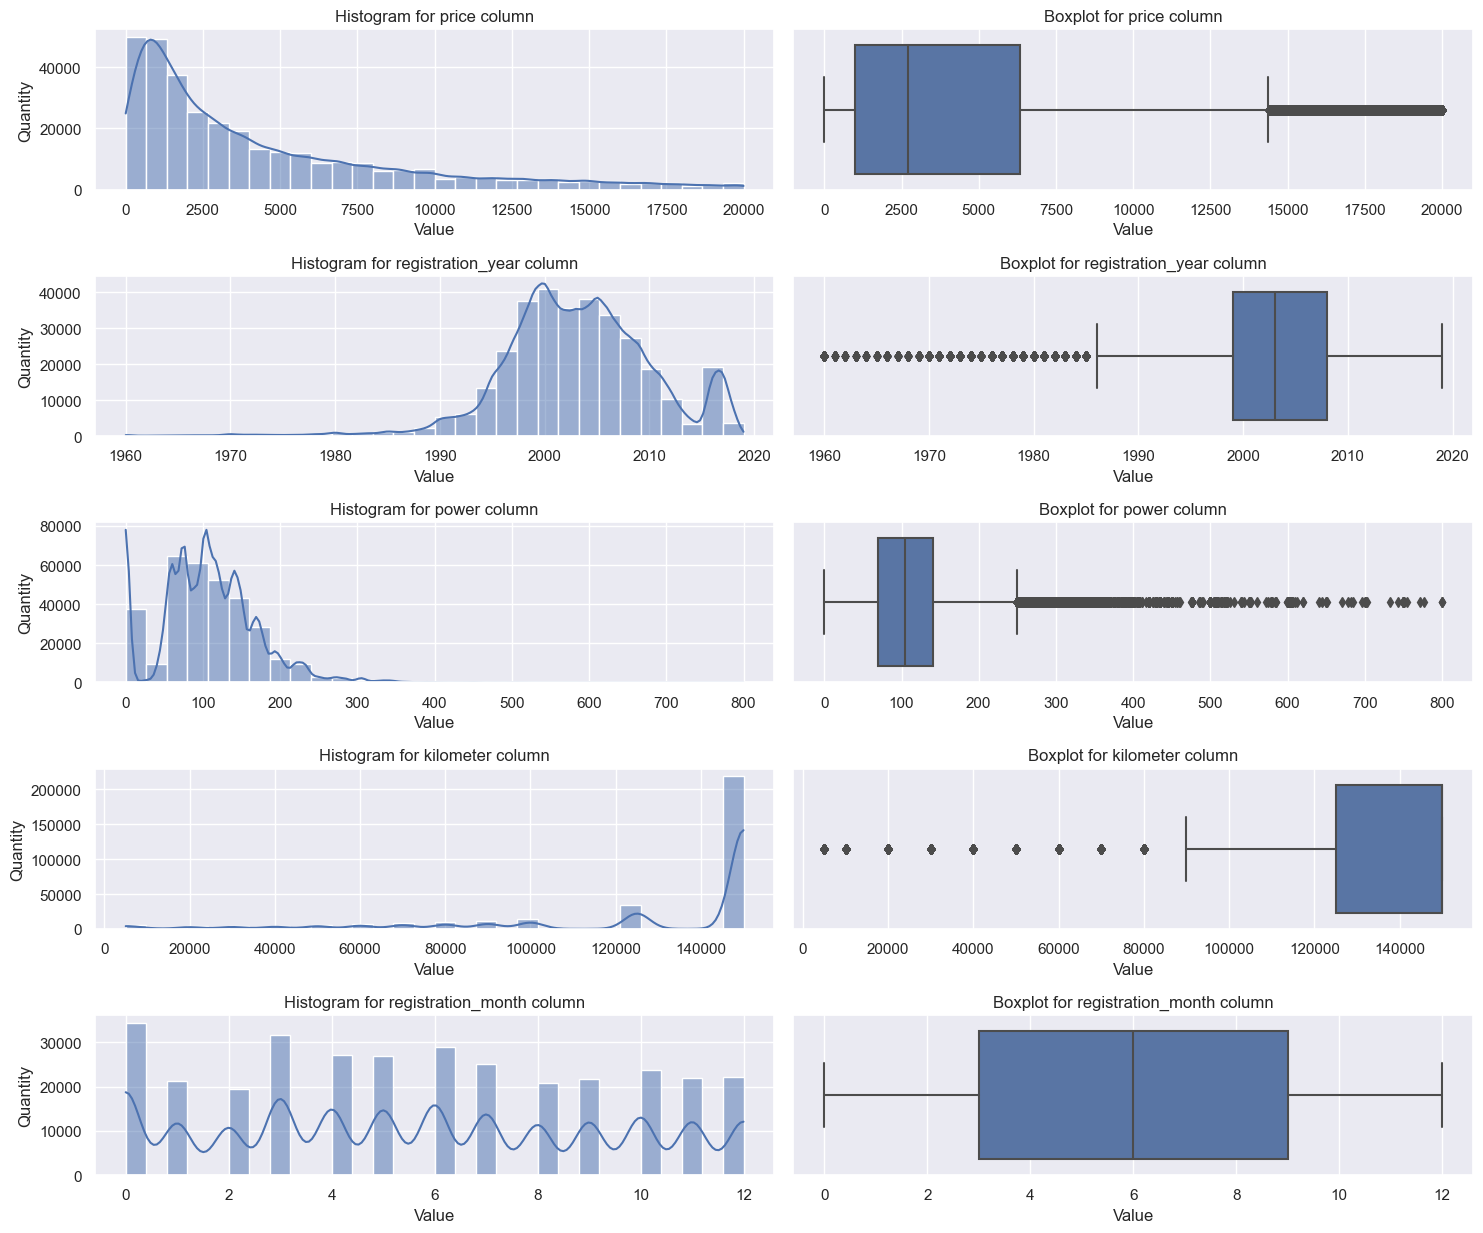

In [17]:
numerical_analysis(autos)

Now there are fewer anomalies in the dataframe

## Correlation Analysis

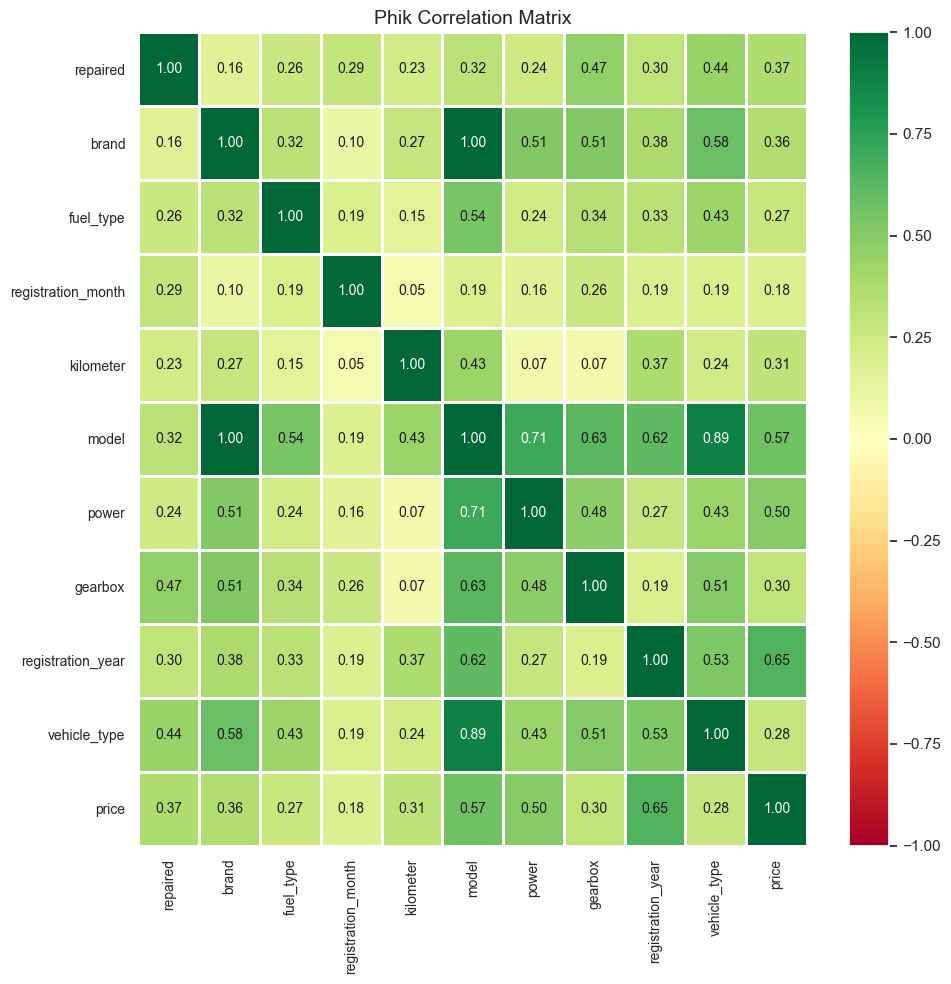

In [18]:
interval_cols = ['price', 'registration_year', 'registration_month', 'power', 'kilometer']

phik_overview = autos.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    title='Phik Correlation Matrix',
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(10, 10)
) 


- There is a weak dependence between the target attribute and `model`, `power`, `registration_year`;
- There is multicollinearity between attributes, but it is explainable (e.g. between `brand` and `model` - it is obvious that certain models are available only from certain manufacturers).

## Data preparation

Dividing the data into samples

In [19]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
target_column = 'price'



ohe_columns = autos.drop(target_column, axis=1).select_dtypes(include=['object']).columns.to_list()
num_columns = autos.drop(target_column, axis=1).select_dtypes(exclude=['object']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(
    autos.drop(target_column, axis=1),
    autos[target_column],
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

encoder = OneHotEncoder(sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])
encoder_col_names = encoder.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)    

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_lr = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_lr = pd.concat([X_test_ohe, X_test_scaled], axis=1)


In [21]:
X_train[ohe_columns] = X_train[ohe_columns].astype('category')
X_test[ohe_columns] = X_test[ohe_columns].astype('category')

## Model Training 

### Metric

We will search for the best model based on the `RMSE' metric. It is not in the sklearn library, so we will create it ourselves

In [22]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

### LightGBM

Creating a dictionary of parameters for enumeration

In [23]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [-1, 10, 20],
    'num_leaves': [30, 50, 70]
}

Looking for the best model metric and hyperparameters

In [24]:
%%time
randomized_search = RandomizedSearchCV(LGBMRegressor(random_state=RANDOM_STATE),
                                        param_grid, 
                                        cv=5,
                                        scoring=rmse_scorer,
                                        n_jobs=-1, 
                                        random_state=RANDOM_STATE)
randomized_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 244505, number of used features: 10
[LightGBM] [Info] Start training from score 4410.959866
CPU times: total: 5.38 s
Wall time: 24.1 s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [-1, 10, 20],
                                        'num_leaves': [30, 50, 70]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False))

Output the result

In [25]:
results = pd.DataFrame(randomized_search.cv_results_)
print(f'Best parameters:\n{randomized_search.best_params_}')
print ('Best model metric on cross-validation sample:', -randomized_search.best_score_)

Best parameters:
{'num_leaves': 70, 'max_depth': -1, 'learning_rate': 0.1}
Best model metric on cross-validation sample: 1742.5121190785248


In [26]:
display(results[['mean_fit_time', 'mean_score_time', 'param_num_leaves', 'param_max_depth', 'param_learning_rate', 'mean_test_score', 'rank_test_score']]
        .sort_values(by='mean_test_score', ascending=False)
        .head(5))

,mean_fit_time,mean_score_time,param_num_leaves,param_max_depth,param_learning_rate,mean_test_score,rank_test_score
5,13.017985,0.098000,70,-1,0.1,-1742.512119,1
7,9.211653,0.115649,70,20,0.1,-1742.512119,1
6,9.110891,0.105369,50,20,0.1,-1756.597246,3
1,10.505761,0.150213,50,10,0.1,-1758.331587,4
9,3.013455,0.069814,30,20,0.2,-1759.798578,5


So, the model with parameters `num_leaves`=70, `max_depth`=20, `learning_rate`=0.1. Its average `RMSE` on the cross-validation sample is `1742.51`, which passes our threshold (`RMSE` < 2500). Also, this model is trained faster than all others in our list of top five models.

### DecisionTreeRegressor

Creating a dictionary of parameters for enumeration

In [27]:
param_grid = {
    'max_depth': [None, 10, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

Looking for the best model metric and hyperparameters

In [28]:
%%time
randomized_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE),
                                        param_grid, 
                                        cv=5,
                                        scoring=rmse_scorer,
                                        n_jobs=-1, 
                                        random_state=RANDOM_STATE)
randomized_search.fit(X_train_lr, y_train)

CPU times: total: 2.34 s
Wall time: 1min 30s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 40],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False))

Output the result

In [29]:
results = pd.DataFrame(randomized_search.cv_results_)
print(f'Best parameters:\n{randomized_search.best_params_}')
print ('Best model metric on cross-validation sample:', -randomized_search.best_score_)

Best parameters:
{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 40}
Best model metric on cross-validation sample: 2036.6073645853248


In [30]:
display(results[['mean_fit_time', 'mean_score_time', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score', 'rank_test_score']]
        .sort_values(by='mean_test_score', ascending=False)
        .head(5))

,mean_fit_time,mean_score_time,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,rank_test_score
9,15.767920,0.125490,40,2,5,-2036.607365,1
0,33.516489,1.594218,None,10,5,-2036.891947,2
6,18.353898,1.162844,10,5,5,-2125.557954,3
7,17.493815,1.263884,10,10,5,-2125.557954,3
1,37.349666,6.426633,10,5,2,-2130.494578,5


The best metrics for `DecisionTreeRegressor` are `max_depth`=40, `min_samples_split`=2, `min_samples_leaf`=5. With these metrics, the model is trained in an average of 15 seconds, which is longer than the `LightGBM` model. The `RMSE` of the model is also significantly larger

### LinearRegression

This model has no hyperparameters worth going over, so just look at the prediction results on a normal sample

In [31]:
%%time
model_lg = LinearRegression()
model_lg.fit(X_train_lr, y_train)


CPU times: total: 7.66 s
Wall time: 4.7 s


LinearRegression()

In [32]:
%%time
y_pred = model_lg.predict(X_test_lr)

CPU times: total: 109 ms
Wall time: 225 ms


In [33]:
print(f'RMSE of the model on the test sample: {rmse(y_test, y_pred)}')

RMSE of the model on the test sample: 2755.2533003739163


The model is trained and makes predictions very quickly, but its RMSE metric is worse than all other models

### Check the best model on a test sample

So, the best model turned out to be `LightGBM` with hyperparameters `num_leaves`=70, `max_depth`=20, `learning_rate`=0.1. This model has the lowest `RMSE` and learns quite fast (relative to other models). Based on the customer's criteria, it is best to use it

Let's test the quality of the model on a test sample

In [34]:
best_model = LGBMRegressor(random_state=RANDOM_STATE,
                           num_leaves=70,
                           max_depth=20,
                           learning_rate=0.1)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 244505, number of used features: 10
[LightGBM] [Info] Start training from score 4410.959866


RMSE of the model on the test sample: 1720.1877086007012
R2 models on test sample: 0.8548570834447301


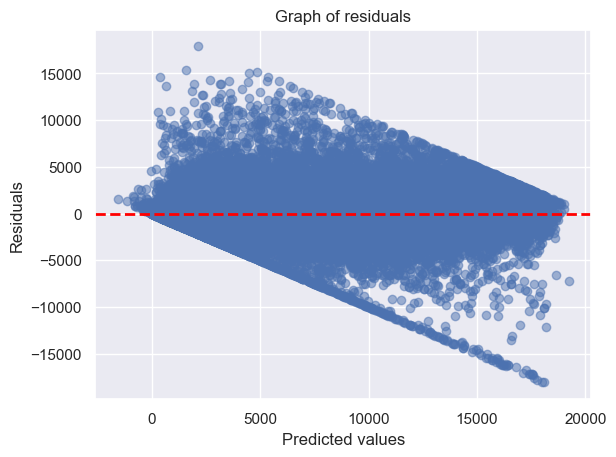

In [36]:
print(f'RMSE of the model on the test sample: {rmse(y_test, y_pred)}')
print(f'R2 models on test sample: {r2_score(y_test, y_pred)}')


plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Graph of residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.show()

The metrics show a good quality model

## Conclusions

### Task Description

We were tasked with building a model that would be able to determine the market value of a car.

The criteria that were important to the customer were:
- Quality of prediction;
- Model training time;
- Model prediction time.

### Description of work steps

1. We downloaded the data
2. We preprocessed the data: removed duplicates, filled in gaps, got rid of unnecessary attributes, changed column names 
3. We did some exploratory analyses
4. Looked to see if there were any strong relationships between the features
5. Split the data into samples and prepare them for model training
6. Tested three models (`LightGMB`, `DecisionTreeRegressor`, `LinearRegression`) and determined the best one (based on customer criteria)

### Final conclusion

We tested three models:

- `LightGBM` (`num_leaves`=70, `max_depth`=20, `learning_rate`=0.1) - the model's `RMSE` metric was 1742.51, which fits the model selection criteria (`RMSE` < 2500); this model has a training time of 9 seconds and a prediction rate of 0.08 seconds

- `DecisionTreeRegressor` (`max_depth`=40, `min_samples_split`=2, `min_samples_leaf`=5) - the model's `RMSE` metric was 2036.61, which also fits the model selection criterion (`RMSE` < 2500); this model has a training time of 24 seconds and a prediction speed of 0.14 seconds

- `LinearRegression` - the model's `RMSE` metric was 2755.25, which does not fit the model selection criterion (`RMSE` < 2500); this model has a training time of 4.6 seconds and a prediction speed of 0.12 seconds


So, the best model is `LightGBM` (`num_leaves`=70, `max_depth`=20, `learning_rate`=0.1) because its metric `RMSE` is the lowest, and the model is trained and makes predictions in a small amount of time. Thus, it should be used by the orderer. Also, we checked the metrics of the model on the test sample: `RMSE` of the model - 1720.19;
`R^2` of the model - 0.85.